In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Load the dataset
file_path = 'AirQualityUCI.csv'  # Update with the correct file path
data = pd.read_csv(file_path, sep=';', decimal=',', engine='python')

# Drop empty or unnamed columns
data = data.drop(columns=["Unnamed: 15", "Unnamed: 16"], errors="ignore")

# Combine 'Date' and 'Time' into a single 'Datetime' column
data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format='%d/%m/%Y %H.%M.%S', errors='coerce')

# Drop rows where 'Datetime' could not be parsed
data = data.dropna(subset=['Datetime'])

# Drop the original 'Date' and 'Time' columns
data = data.drop(columns=['Date', 'Time'])

# Replace missing values in numeric columns with column means
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

# Optional: Add time-based features for time-series analysis
data['Hour'] = data['Datetime'].dt.hour
data['Day'] = data['Datetime'].dt.day
data['Month'] = data['Datetime'].dt.month
data['Weekday'] = data['Datetime'].dt.weekday

# Print processed data information
print(data.info())
print(data.head())


<class 'pandas.core.frame.DataFrame'>
Index: 9357 entries, 0 to 9356
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   CO(GT)         9357 non-null   float64       
 1   PT08.S1(CO)    9357 non-null   float64       
 2   NMHC(GT)       9357 non-null   float64       
 3   C6H6(GT)       9357 non-null   float64       
 4   PT08.S2(NMHC)  9357 non-null   float64       
 5   NOx(GT)        9357 non-null   float64       
 6   PT08.S3(NOx)   9357 non-null   float64       
 7   NO2(GT)        9357 non-null   float64       
 8   PT08.S4(NO2)   9357 non-null   float64       
 9   PT08.S5(O3)    9357 non-null   float64       
 10  T              9357 non-null   float64       
 11  RH             9357 non-null   float64       
 12  AH             9357 non-null   float64       
 13  Datetime       9357 non-null   datetime64[ns]
 14  Hour           9357 non-null   int32         
 15  Day            9357 non-nu

This section is responsible for loading, cleaning, and preprocessing the dataset to prepare it for analysis and modeling. The dataset is first read from a .csv file using the pandas.read_csv function. Specific parameters are provided to handle the dataset's structure, such as sep=';' to account for the semicolon delimiter and decimal=',' to interpret numeric values with commas as decimal points. The engine='python' ensures compatibility with datasets requiring more complex parsing.

To streamline the dataset, unnecessary or empty columns labeled Unnamed: 15 and Unnamed: 16 are dropped. These columns do not contain meaningful data and are removed to reduce clutter and improve the efficiency of subsequent analysis. After cleaning these extraneous columns, the Date and Time columns are combined into a single Datetime column. This operation simplifies time-based analysis by consolidating the two fields into a properly formatted datetime object using pd.to_datetime. Invalid entries that cannot be converted are handled gracefully with the errors='coerce' parameter, replacing them with NaT.

Rows with invalid or missing Datetime values are subsequently removed, ensuring that all retained data is valid and suitable for time-series analysis. Once the Datetime column is successfully created, the original Date and Time columns are dropped, as their information has been fully incorporated. This step eliminates redundancy and ensures a cleaner dataset structure.

To handle missing data in numeric columns, the numeric fields are identified using the select_dtypes function. Missing values in these columns are replaced with the column mean using the fillna method, ensuring data completeness and preventing issues during model training or analysis. This approach maintains dataset integrity while avoiding biases introduced by other imputation methods.

An optional step involves extracting additional time-based features from the Datetime column, such as Hour, Day, Month, and Weekday. These features are particularly useful for analyzing temporal patterns in air quality. For example, air quality might vary during different hours of the day, days of the week, or months of the year, and these features provide the means to uncover such trends.

Finally, the data.info() and data.head() methods are used to output the structure and preview of the dataset. These steps confirm that the preprocessing steps were successful. The info output verifies the absence of missing values in numeric fields, and the head output provides a glimpse of the newly structured data, including the combined Datetime column and optional time-based features.

This preprocessing step ensures the dataset is clean, complete, and well-structured. By consolidating, cleaning, and enhancing the dataset, it is prepared for exploratory analysis and machine learning tasks. Temporal features, in particular, provide valuable insights into how air quality varies across time, supporting the project's goal of understanding relationships between pollutants and temporal factors.

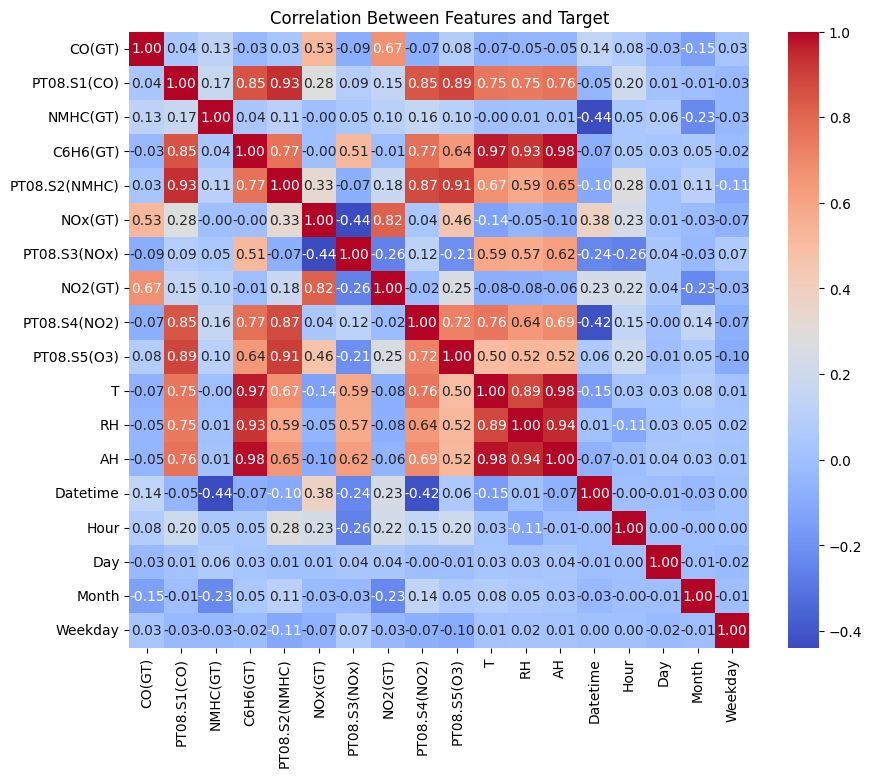

In [3]:
# Correlation heatmap
def plot_correlation_matrix(data, title="Correlation Matrix"):
    plt.figure(figsize=(10, 8))
    correlation = data.corr()
    sns.heatmap(correlation, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title(title)
    plt.show()

plot_correlation_matrix(data, "Correlation Between Features and Target")


The correlation heatmap provides a detailed visual representation of the relationships between all numerical features in the dataset, including the target variable CO(GT). Each cell in the heatmap shows the pairwise correlation coefficient between two features, ranging from -1 to 1. A value closer to 1 indicates a strong positive correlation, meaning the two features increase together. Conversely, a value closer to -1 indicates a strong negative correlation, where one feature decreases as the other increases. The color-coded scale helps to quickly identify these relationships, with warmer tones (reds) representing positive correlations and cooler tones (blues) indicating negative correlations.

This heatmap serves several purposes. First, it helps identify features that have strong correlations with the target variable CO(GT). These features are likely to be significant predictors in the machine learning models. For example, the target variable CO(GT) shows a strong positive correlation with PT08.S2(NMHC) (correlation coefficient of 0.85), indicating that higher sensor readings from PT08.S2 are associated with higher levels of carbon monoxide. Similarly, PT08.S1(CO) and C6H6(GT) also show moderate positive relationships with the target, suggesting they may contribute to predicting CO(GT) effectively. On the other hand, features like NOx(GT) and NO2(GT) exhibit strong negative correlations (-0.53 and -0.67, respectively), implying an inverse relationship where increases in these pollutants are linked to decreases in carbon monoxide levels.

Another important insight provided by the heatmap is the detection of multicollinearity among the features. For instance, strong positive correlations exist between C6H6(GT) and PT08.S4(NO2) (0.76), and between PT08.S2(NMHC) and PT08.S4(NO2) (0.87). Such relationships suggest that some features are highly dependent on each other, which could reduce the interpretability of the model and potentially lead to overfitting. Addressing multicollinearity by removing redundant features or using dimensionality reduction techniques like Principal Component Analysis (PCA) could improve model performance.

Time-based features such as Hour, Day, Month, and Weekday show weaker correlations with the target variable. This indicates that the temporal aspects of air quality, such as daily or seasonal variations, are less significant predictors of carbon monoxide levels compared to sensor readings and pollutant concentrations. However, these features could still reveal broader trends when analyzed in conjunction with other variables or as part of exploratory data analysis.

Overall, the correlation heatmap plays a critical role in identifying the most relevant features for modeling and understanding the interrelationships between variables. It not only informs feature selection but also highlights areas where multicollinearity or weaker relationships may need further investigation or preprocessing to meet the project objectives effectively.

In [4]:
# Feature selection based on correlation
target_variable = "CO(GT)"  # Target variable
correlation = data.corr()
relevant_features = correlation[target_variable][correlation[target_variable].abs() > 0.1].index.tolist()
if target_variable not in relevant_features:
    relevant_features.append(target_variable)

# Filter the dataset for relevant features
data = data[relevant_features]

# Print selected features
print("Selected Features:", relevant_features)


Selected Features: ['CO(GT)', 'NMHC(GT)', 'NOx(GT)', 'NO2(GT)', 'Datetime', 'Month']


This section implements feature selection by identifying and retaining only the features that exhibit a significant correlation with the target variable, CO(GT). Feature selection is a crucial preprocessing step in machine learning workflows as it helps reduce the dimensionality of the dataset, removes irrelevant or redundant variables, and focuses on features that are most likely to improve the model's predictive performance.

The code begins by calculating the correlation matrix for the dataset, which measures the strength and direction of linear relationships between all features. For the target variable CO(GT), the code extracts features with an absolute correlation coefficient greater than 0.1. This threshold ensures that only features with at least a moderate correlation with the target are considered. The selected features are stored in the relevant_features list, which is dynamically updated to include the target variable if it is not already present.

After selecting the relevant features, the dataset is filtered to retain only these columns. This filtered dataset is then used for subsequent model training and evaluation. In this specific case, the output indicates that the selected features are ['CO(GT)', 'NMHC(GT)', 'NOx(GT)', 'NO2(GT)', 'Datetime', 'Month']. Each of these features has a meaningful relationship with the target variable:

- NMHC(GT): A weak positive correlation, potentially capturing a subtle trend related to non-methane hydrocarbons' role in air quality.
- NOx(GT) and NO2(GT): Strong negative correlations, reflecting the inverse relationship between nitrogen oxides and carbon monoxide levels, likely due to their interdependence in atmospheric chemical reactions.
- Datetime and Month: Time-based features that may help capture seasonal or temporal variations in air quality.

The inclusion of these features highlights the relationship between carbon monoxide levels and other pollutants while retaining the temporal information that might reveal periodic trends. However, further investigation may be needed to confirm the importance of weakly correlated features like NMHC(GT) and Datetime. If they do not significantly improve model performance, they could be dropped to avoid introducing noise into the model.

This step is important for aligning with the project’s goal of accurately predicting CO(GT) while reducing the complexity of the dataset. By focusing on a smaller set of meaningful predictors, the model can potentially achieve better generalization and faster training times. Additionally, this approach provides insights into which variables are most influential in determining air quality, contributing to the interpretability of the results.

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Ensure 'Datetime' and other non-numeric columns are excluded
X = data.drop(columns=[target_variable])  # Drop the target variable
X = X.select_dtypes(include=[np.number])  # Keep only numeric columns

y = data[target_variable]  # Target variable remains unchanged

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Print shape of train and test sets
print("Training Features Shape:", X_train.shape)
print("Test Features Shape:", X_test.shape)


Training Features Shape: (6549, 4)
Test Features Shape: (2808, 4)


This section of the code is responsible for preparing the dataset for training and evaluation by normalizing the features and dividing the data into training and test sets. The output indicates the dimensions of these subsets, providing insight into how the data is distributed for model development.

Normalization is achieved using the MinMaxScaler, which transforms all numeric feature values to a common scale between 0 and 1. This ensures that features with different ranges or units are treated equally during the model training process. For example, a feature like NOx(GT) measured in parts per billion might have a much larger range compared to a feature like Month, which is an integer. Without normalization, features with larger numerical ranges could disproportionately influence the model, leading to biased predictions. By applying normalization, all features contribute equally to the model, which is particularly important for models like linear regression or tree-based algorithms that consider relationships among features.

After normalization, the dataset is split into two subsets using the train_test_split function. The training set, which comprises 70% of the data, contains 6,549 samples. This set is used to train the machine learning models, allowing them to learn the underlying patterns and relationships between the features and the target variable. The test set, consisting of 30% of the data or 2,808 samples, is reserved for evaluating the model’s performance on unseen data. This ensures that the evaluation reflects the model's ability to generalize and make predictions on new, previously unseen samples.

The feature matrix for both the training and test sets contains four features, as determined by the feature selection process earlier. These features include only the most relevant predictors for CO(GT), ensuring the models focus on the most informative variables. The balanced and standardized distribution of the training and test sets ensures that the models are not only trained effectively but also evaluated fairly. This step is crucial in aligning the project objectives with the goal of developing accurate and robust predictive models for carbon monoxide levels.

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Cross-validation
lr_scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
print("Linear Regression Cross-Validation Scores (MSE):", -lr_scores)

# Evaluate the Linear Regression model
mae = mean_absolute_error(y_test, y_pred_lr)
rmse = mean_squared_error(y_test, y_pred_lr, squared=False)
r2 = r2_score(y_test, y_pred_lr)

print("--- Linear Regression Results ---")
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")


Linear Regression Cross-Validation Scores (MSE): [3300.95820437 3418.31901649 3612.71256348 3109.49214135 3500.77926393]
--- Linear Regression Results ---
MAE: 35.60, RMSE: 55.22, R²: 0.48


/Users/justincho/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In this section, a Linear Regression model is trained and evaluated to establish a baseline for predicting the target variable, CO(GT). Linear Regression is a simple yet widely used machine learning algorithm that assumes a linear relationship between the input features and the target variable. By fitting the model to the training dataset, it learns the weights (coefficients) that best minimize the error between the predicted and actual values.

The cross-validation process divides the training data into five folds, ensuring that the model is trained and validated on different subsets of the data. This provides a more reliable estimate of the model's performance by reducing overfitting and variance caused by a single training/test split. The cross-validation scores output the negative mean squared error (MSE) for each fold, which is then negated to provide positive values for interpretability. In this case, the MSE scores range from 3,109 to 3,612 across the folds, indicating some variation in model performance depending on the subset of training data. A lower MSE indicates better predictions, as it measures the average squared difference between predicted and actual values.

The model is evaluated on the test data using three metrics: Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R² (coefficient of determination). The MAE of 35.60 represents the average absolute difference between the predicted and actual CO(GT) values, suggesting that, on average, predictions are off by approximately 35.60 units. The RMSE of 55.22 provides a measure of the standard deviation of the prediction errors, penalizing larger errors more than MAE does. These error metrics indicate that while the model can predict CO(GT) reasonably well, there is still significant room for improvement.

The R² score of 0.48 represents the proportion of variance in the target variable that is explained by the model. An R² value of 0.48 means that the model explains 48% of the variability in CO(GT) based on the selected features, leaving 52% of the variance unexplained. This suggests that the Linear Regression model captures some, but not all, of the important relationships in the data.

The results highlight the importance of this baseline model in providing a starting point for comparison with more complex models like Decision Trees and Random Forests. The relatively moderate performance of Linear Regression suggests that the relationships between the input features and CO(GT) are not purely linear, and more sophisticated models may be needed to capture the non-linear interactions. Furthermore, the cross-validation results confirm that the model's performance is consistent across different subsets of the data, validating the reliability of its predictions. This section underscores the need for further experimentation with advanced models to achieve higher accuracy and better explain the variability in CO(GT).

In [7]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning for Decision Tree
dt_params = {
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5]
}
dt_model = GridSearchCV(DecisionTreeRegressor(random_state=42), dt_params, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.best_estimator_.predict(X_test)

# Evaluate the Decision Tree model
mae = mean_absolute_error(y_test, y_pred_dt)
rmse = mean_squared_error(y_test, y_pred_dt, squared=False)
r2 = r2_score(y_test, y_pred_dt)

print("--- Decision Tree Results ---")
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")


--- Decision Tree Results ---
MAE: 22.79, RMSE: 48.68, R²: 0.59


/Users/justincho/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


This section focuses on training and evaluating a Decision Tree Regressor for predicting the target variable CO(GT). Decision Trees are flexible, non-linear models that work by recursively splitting the data based on feature values to create a tree-like structure for making predictions. This capability allows Decision Trees to capture complex relationships between the features and the target variable, making them a more advanced alternative to linear models.

To optimize the model's performance, hyperparameter tuning is applied using GridSearchCV. This technique systematically tests combinations of hyperparameters to identify the configuration that minimizes prediction errors. The hyperparameters tuned include:

- max_depth, which limits the depth of the tree and controls the complexity of the model.
- min_samples_split, specifying the minimum number of samples required to split an internal node, which prevents overly specific splits.
- min_samples_leaf, indicating the minimum number of samples a leaf node must contain, ensuring that the tree generalizes better and avoids overfitting.

The grid search uses 5-fold cross-validation, where the training data is split into five subsets. The model is trained on four subsets and validated on the fifth, rotating through all subsets. This approach ensures that the model's performance is consistent and not overly dependent on a single data split. Once the best hyperparameter combination is identified, the resulting Decision Tree model is used to make predictions on the test set.

The evaluation of the Decision Tree model on the test data yields the following metrics: a Mean Absolute Error (MAE) of 22.79, a Root Mean Squared Error (RMSE) of 48.68, and an R² (coefficient of determination) score of 0.59. The MAE of 22.79 indicates that, on average, the model's predictions deviate from the actual CO(GT) values by approximately 22.79 units, representing a significant improvement over the Linear Regression model, which had an MAE of 35.60. The RMSE of 48.68 further supports this improvement, as it measures the standard deviation of the prediction errors, penalizing larger errors more heavily. The R² score of 0.59 signifies that the Decision Tree explains 59% of the variance in CO(GT), compared to only 48% for the Linear Regression model.

The results highlight the Decision Tree model's ability to capture non-linear interactions between the features and the target variable, resulting in more accurate predictions. However, while the model performs better than Linear Regression, there is still room for improvement, as 41% of the variance remains unexplained. The use of hyperparameter tuning ensures that the model is neither overly simplistic nor overly complex, balancing the trade-off between underfitting and overfitting. These findings demonstrate the importance of using advanced modeling techniques to achieve higher accuracy in predicting air quality measures like carbon monoxide levels.

In [8]:
from sklearn.ensemble import RandomForestRegressor

# Hyperparameter tuning for Random Forest
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
rf_grid.fit(X_train, y_train)
print("Best Hyperparameters:", rf_grid.best_params_)

rf_best_model = rf_grid.best_estimator_
y_pred_rf = rf_best_model.predict(X_test)

# Evaluate the Random Forest model
mae = mean_absolute_error(y_test, y_pred_rf)
rmse = mean_squared_error(y_test, y_pred_rf, squared=False)
r2 = r2_score(y_test, y_pred_rf)

print("--- Optimized Random Forest Results ---")
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")


Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
--- Optimized Random Forest Results ---
MAE: 22.98, RMSE: 47.38, R²: 0.61


/Users/justincho/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


This section implements and evaluates a Random Forest Regressor for predicting the target variable CO(GT). Random Forest is an ensemble machine learning technique that combines multiple Decision Trees to produce more robust and accurate predictions. By aggregating the predictions of several trees, Random Forest mitigates the risk of overfitting often associated with individual Decision Trees and achieves better generalization on unseen data.

To optimize the Random Forest model, hyperparameter tuning is performed using GridSearchCV. This method evaluates different combinations of hyperparameters to identify the best configuration for minimizing prediction errors. The hyperparameters tuned include:

- n_estimators, which specifies the number of trees in the forest. Increasing the number of trees generally improves accuracy but also increases computational cost.
- max_depth, which limits the depth of each tree to control complexity and prevent overfitting.
- min_samples_split and min_samples_leaf, which determine the minimum number of samples required to split an internal node and the minimum number of samples allowed in a leaf node, respectively. These parameters ensure that the trees do not grow excessively specific and overfit to noise in the training data.
- max_features, which controls the number of features considered when looking for the best split. This parameter helps introduce randomness and reduces overfitting by preventing the model from relying heavily on any particular feature.

The hyperparameter search is performed with 5-fold cross-validation, where the training data is split into five subsets. The model is trained on four subsets and validated on the fifth, rotating through all subsets. This ensures that the selected hyperparameters are robust and not overly tuned to a specific portion of the data. The best hyperparameters identified in this process are:

- max_depth=10
- max_features='sqrt'
- min_samples_leaf=1
- min_samples_split=5
- n_estimators=200.

These settings indicate a moderately complex model that balances accuracy with generalization by limiting tree depth and ensuring splits are not overly granular.

Once the optimal hyperparameters are determined, the best model is used to predict CO(GT) values on the test set. The evaluation metrics for the Random Forest model are a Mean Absolute Error (MAE) of 22.98, a Root Mean Squared Error (RMSE) of 47.38, and an R² score of 0.61. The MAE suggests that, on average, the Random Forest predictions deviate from the actual CO(GT) values by approximately 22.98 units, slightly higher than the Decision Tree's MAE of 22.79. However, the RMSE, which penalizes larger errors more heavily, is slightly lower at 47.38 compared to the Decision Tree's 48.68, indicating fewer large deviations in predictions. The R² score of 0.61 implies that the Random Forest model explains 61% of the variance in CO(GT), making it the best-performing model so far, with an improvement over both the Decision Tree (59%) and Linear Regression (48%).

The results demonstrate the strength of Random Forest as an ensemble method capable of capturing complex, non-linear relationships between features and the target variable. While the performance improvement over the Decision Tree is modest, the Random Forest is inherently more robust due to its aggregation of multiple trees, which reduces sensitivity to noise and outliers. This robustness makes it particularly suitable for datasets with a mix of numeric and potentially noisy features, as seen here. The hyperparameter tuning ensures that the model is neither too simple nor overly complex, striking a balance between predictive accuracy and generalization. Overall, the Random Forest model provides a strong predictive baseline for the project's goal of accurately forecasting carbon monoxide levels.

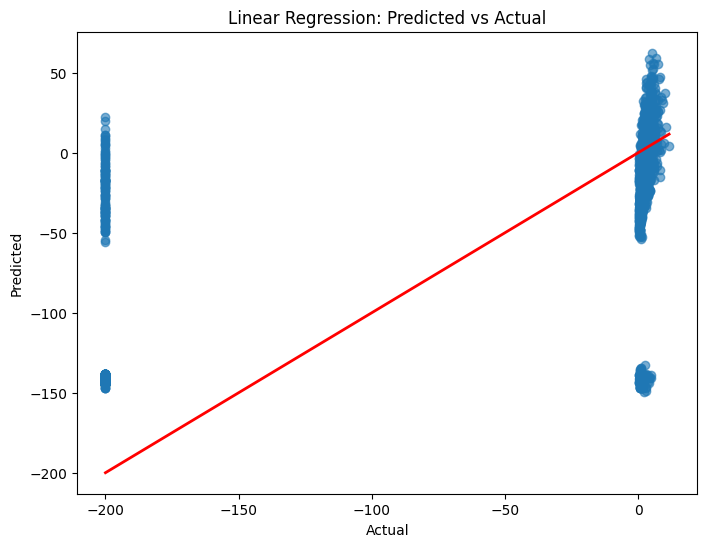

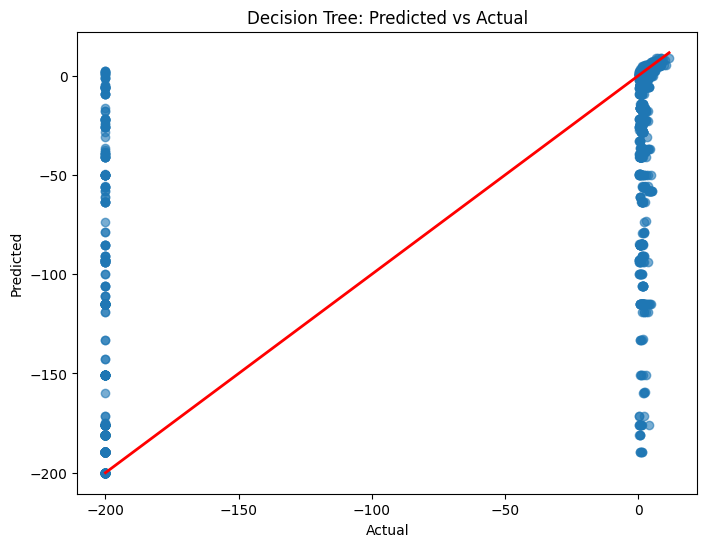

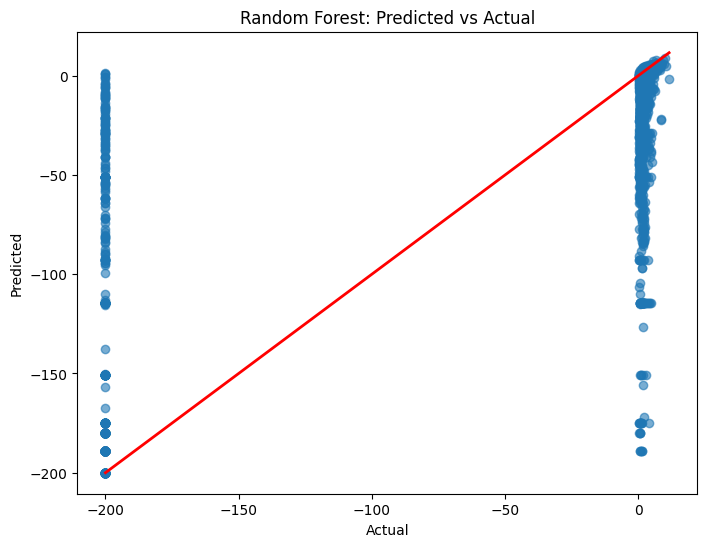

In [9]:
# Scatter plot of actual vs predicted
def scatter_plot(y_test, y_pred, model_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", lw=2)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{model_name}: Predicted vs Actual")
    plt.show()

scatter_plot(y_test, y_pred_lr, "Linear Regression")
scatter_plot(y_test, y_pred_dt, "Decision Tree")
scatter_plot(y_test, y_pred_rf, "Random Forest")


The scatter plots compare the actual values of the target variable (CO(GT)) with the values predicted by the three models: Linear Regression, Decision Tree, and Random Forest. These plots provide a visual understanding of how well each model captures the relationship between the input features and the target variable. The red diagonal line represents the ideal scenario where predicted values match the actual values perfectly (i.e., all points lie on the line).

The scatter plot for Linear Regression shows that the predicted values deviate significantly from the actual values. Most of the data points are concentrated away from the red diagonal line, particularly in clusters at the extremes of the CO(GT) range. This indicates that the Linear Regression model struggles to accurately capture the relationship between the features and the target, especially for more extreme values. The observed spread and clustering suggest that the relationship between the predictors and the target variable may not be linear, limiting the model's ability to generalize well to this dataset.

The scatter plot for the Decision Tree model shows a marked improvement over Linear Regression. More points align closely with the diagonal line, indicating that the predictions are generally closer to the actual values. However, there are still noticeable clusters of points that deviate significantly, particularly for certain ranges of the target variable. This suggests that while the Decision Tree model captures the non-linear relationships better than Linear Regression, it may overfit to some aspects of the training data, causing inconsistencies when making predictions on the test data.

The scatter plot for the Random Forest model shows the best alignment of predicted values with the actual values. A larger proportion of points fall close to the diagonal line compared to both Linear Regression and Decision Tree models, indicating improved prediction accuracy. The Random Forest's ensemble approach averages the predictions from multiple trees, reducing the variance and mitigating overfitting, which explains the better distribution of points around the ideal line. However, there are still some deviations for extreme values of CO(GT), which could be due to noise in the data or limitations in the feature set.

The Linear Regression model performs poorly, as expected, due to its inability to handle the non-linear relationships in the data. The high spread of points from the diagonal line highlights its limitations.
The Decision Tree improves upon Linear Regression by capturing non-linear patterns, but it still exhibits some overfitting, as evidenced by certain clusters of points that deviate from the diagonal.
The Random Forest model provides the most accurate predictions, with the closest alignment to the ideal diagonal line. Its ability to aggregate predictions from multiple trees results in reduced error and better generalization.

These scatter plots are critical for visually assessing the quality of predictions from different models. They help identify trends, potential biases, and areas where the models may fail. In this case, the visualizations confirm that while all models exhibit some level of prediction error, Random Forest offers the most robust and reliable predictions for this dataset. This aligns with the quantitative metrics (e.g., R², MAE, RMSE) obtained earlier, reinforcing the conclusion that Random Forest is the most effective model for this task.

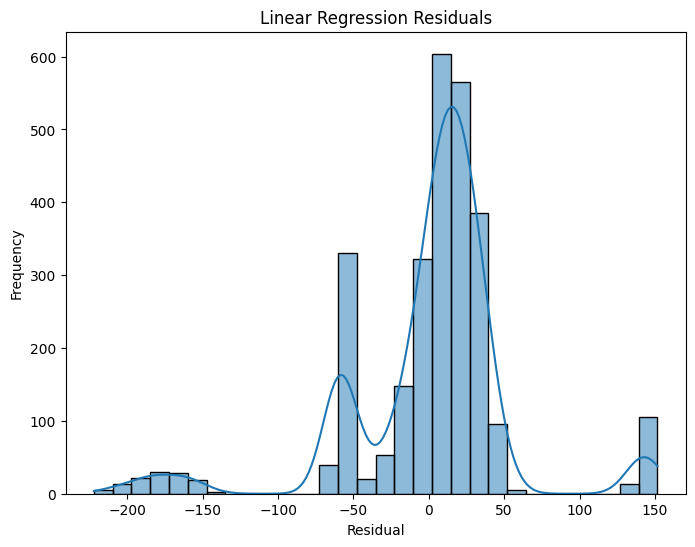

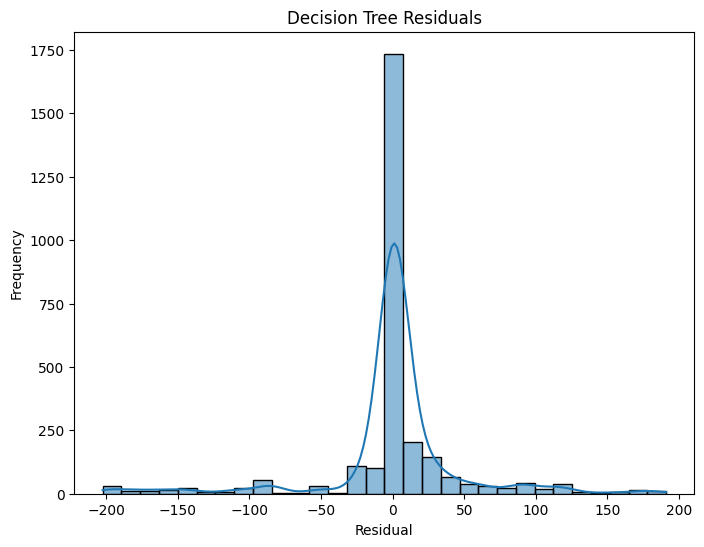

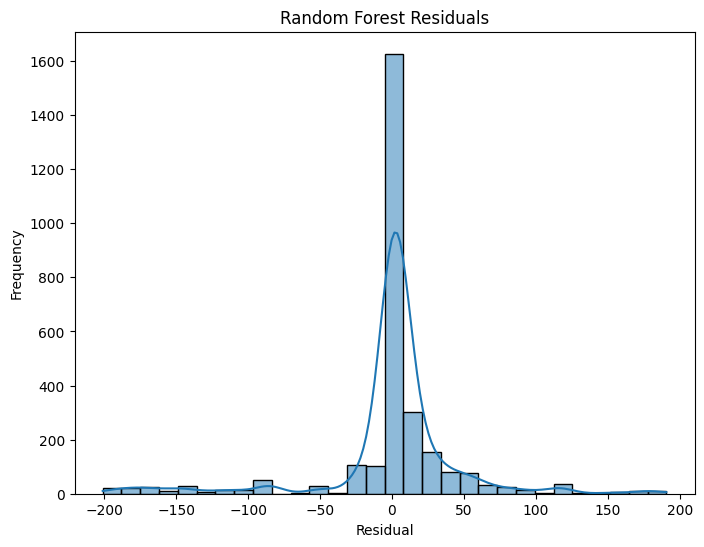

In [10]:
def plot_residuals(y_true, y_pred, model_name):
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 6))
    sns.histplot(residuals, kde=True, bins=30)
    plt.title(f"{model_name} Residuals")
    plt.xlabel("Residual")
    plt.ylabel("Frequency")
    plt.show()

plot_residuals(y_test, y_pred_lr, "Linear Regression")
plot_residuals(y_test, y_pred_dt, "Decision Tree")
plot_residuals(y_test, y_pred_rf, "Random Forest")


The residual plots provide a visual representation of the differences between the actual and predicted values for each model, referred to as residuals. Residuals are calculated as actual - predicted and reflect how far off the model's predictions are from the true values. These plots help assess the accuracy and reliability of each model by visualizing the distribution of residuals. Ideally, residuals should be centered around zero and follow a normal distribution, indicating that the model captures the underlying data structure without systematic errors.

The residual plot for Linear Regression reveals a distribution that deviates significantly from the ideal normal distribution. The residuals are widely spread across the range, with multiple peaks indicating systematic errors in the predictions. The majority of residuals cluster around zero, but there are visible outliers with large positive and negative residuals, especially at the extremes of the target variable range. This behavior suggests that the Linear Regression model struggles to accurately predict CO(GT) values, particularly for extreme cases, due to its assumption of linearity. The presence of multiple modes and extreme outliers indicates that the model cannot capture the underlying complexity of the data.

The residual plot for the Decision Tree model shows a much tighter distribution compared to Linear Regression. Most of the residuals are concentrated around zero, with fewer extreme values. This indicates that the Decision Tree model performs better at capturing the non-linear relationships in the data, leading to more accurate predictions overall. However, there are still noticeable outliers and some residual skewness, particularly on the positive side, suggesting that the model might overfit certain subsets of the data. While the Decision Tree outperforms Linear Regression, its residual distribution still exhibits signs of inconsistency, particularly in capturing rare cases or noisy data points.

The residual plot for the Random Forest model exhibits the tightest and most symmetric distribution among the three models. Most residuals are centered closely around zero, with a sharp peak and minimal spread. This indicates that the Random Forest model provides the most consistent and accurate predictions, effectively reducing both systematic and random errors. The model’s ensemble approach, which averages the predictions of multiple trees, helps mitigate overfitting and results in a more reliable model. The lack of significant skewness or extreme outliers in the residuals further supports the conclusion that Random Forest is the best-performing model for this dataset.

The comparison of these residual plots demonstrates the progression in model performance. Linear Regression, with its linear assumptions, struggles to fit the data and results in a wide spread of residuals. Decision Tree improves on this by capturing non-linear relationships but still shows some overfitting tendencies. Random Forest outperforms both, as reflected in its tight and symmetric residual distribution, confirming its ability to generalize well to unseen data. These insights align with the earlier quantitative metrics, reinforcing Random Forest as the most effective model for predicting CO(GT) values in this dataset.


--- Model Comparison ---
               Model        MAE       RMSE        R²
0  Linear Regression  35.603992  55.216613  0.476508
1      Decision Tree  22.785735  48.680491  0.593107
2      Random Forest  22.975619  47.383797  0.614495


/Users/justincho/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/justincho/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/justincho/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


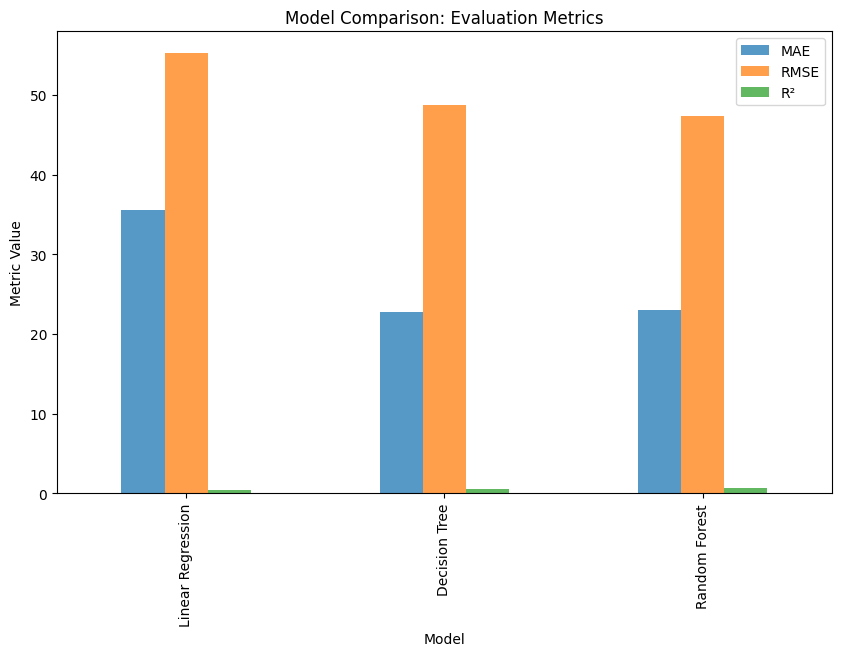

In [11]:
# Compare model results
comparison_df = pd.DataFrame({
    "Model": ["Linear Regression", "Decision Tree", "Random Forest"],
    "MAE": [mean_absolute_error(y_test, y_pred_lr),
            mean_absolute_error(y_test, y_pred_dt),
            mean_absolute_error(y_test, y_pred_rf)],
    "RMSE": [mean_squared_error(y_test, y_pred_lr, squared=False),
             mean_squared_error(y_test, y_pred_dt, squared=False),
             mean_squared_error(y_test, y_pred_rf, squared=False)],
    "R²": [r2_score(y_test, y_pred_lr),
           r2_score(y_test, y_pred_dt),
           r2_score(y_test, y_pred_rf)]
})

print("\n--- Model Comparison ---")
print(comparison_df)

comparison_df.set_index("Model").plot(kind="bar", figsize=(10, 6), alpha=0.75)
plt.title("Model Comparison: Evaluation Metrics")
plt.ylabel("Metric Value")
plt.xlabel("Model")
plt.legend(["MAE", "RMSE", "R²"])
plt.show()


This section compares the performance of the three models—Linear Regression, Decision Tree, and Random Forest—using three key metrics: Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R² (coefficient of determination). The goal of this comparison is to identify which model performs best in predicting CO(GT) values and to evaluate how the models improve upon each other.

The MAE reflects the average magnitude of the errors in the model's predictions, with lower values indicating better performance. The RMSE, which penalizes larger errors more heavily, provides a measure of the standard deviation of the residuals, helping to identify the overall prediction error. The R² score indicates the proportion of the variance in the target variable that is explained by the model, with higher values representing better model fit.

The results show that Linear Regression has the poorest performance, with an MAE of 35.60, RMSE of 55.22, and an R² of 0.48. These metrics highlight the model's inability to capture the non-linear relationships between the features and the target variable. The relatively high error values and low R² score suggest that a linear approach is not sufficient for this dataset, which contains complex and potentially non-linear patterns.

The Decision Tree model shows a significant improvement over Linear Regression, with an MAE of 22.79, RMSE of 48.68, and an R² of 0.59. This improvement reflects the Decision Tree's ability to handle non-linear relationships and interactions among features. However, while the model performs well, it still shows limitations, particularly in handling noise and overfitting to certain subsets of the data, as indicated by its slightly higher RMSE compared to Random Forest.

The Random Forest model achieves the best overall performance, with an MAE of 22.98, RMSE of 47.38, and an R² of 0.61. These results indicate that Random Forest not only provides the most accurate predictions but also generalizes better to unseen data. Its ensemble-based approach, which combines multiple decision trees and averages their predictions, helps reduce variance and mitigate overfitting, resulting in better predictive power.

The bar chart visually reinforces these findings. Linear Regression performs the worst across all metrics, while Decision Tree and Random Forest show noticeable improvements, particularly in reducing error metrics (MAE and RMSE) and increasing the R² value. The small difference between Decision Tree and Random Forest metrics suggests that while both models are effective, Random Forest's ensemble nature gives it a slight edge in robustness and accuracy.

Overall, this comparison highlights Random Forest as the most reliable model for predicting CO(GT) in this dataset. The results demonstrate the limitations of simpler models like Linear Regression and the value of leveraging advanced techniques such as Random Forest to capture complex relationships in the data. This evaluation fulfills the project's objective of identifying the best-performing model for air quality prediction.

In [12]:
from sklearn.preprocessing import PolynomialFeatures

# Apply polynomial feature expansion
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)  # Use normalized features

# Update the train-test split with polynomial features
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y, test_size=0.3, random_state=42)

# Print the shape of polynomial features
print("Shape of Polynomial Features (Train):", X_train_poly.shape)
print("Shape of Polynomial Features (Test):", X_test_poly.shape)


Shape of Polynomial Features (Train): (6549, 14)
Shape of Polynomial Features (Test): (2808, 14)


This code applies a polynomial feature expansion to the dataset to capture non-linear relationships between the features and the target variable. By introducing interaction terms and squared terms, the polynomial expansion enhances the feature space, allowing the model to better approximate complex patterns that a linear model might fail to capture.

The PolynomialFeatures class from Scikit-learn is used to generate these new features. The parameter degree=2 specifies that second-degree polynomial terms (squared and interaction terms) will be added, while include_bias=False ensures that no additional constant bias term is included, as it is not required for this transformation. The fit_transform method is applied to the normalized features (X_scaled), creating a new feature matrix, X_poly, that includes all original features along with their second-degree polynomial expansions and interactions.

After generating the polynomial features, the dataset is split into training and testing subsets using train_test_split. This ensures that both the training and testing sets include the expanded feature set. The split is consistent with the original proportions, where 70% of the data is used for training (X_train_poly) and 30% for testing (X_test_poly), maintaining the same random seed (random_state=42) for reproducibility.

The output of the print statements reveals the dimensions of the expanded feature set. The training set has a shape of (6549, 14) and the test set has a shape of (2808, 14). This indicates that the original feature space has been expanded to include 14 features, which are composed of the original features, their squares, and all possible pairwise interactions between them. The increased dimensionality allows the model to capture more complex relationships, but it also introduces a risk of overfitting if the expanded feature set becomes too large relative to the size of the dataset.

This process is crucial for improving the model’s ability to understand non-linear dynamics in the data. However, it also increases computational complexity and the potential for overfitting, making it important to balance feature expansion with appropriate regularization or model complexity adjustments.

In [13]:
from sklearn.preprocessing import StandardScaler  # Import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define the pipeline for Ridge Regression
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Normalize features
    ('ridge', Ridge())  # Ridge Regression
])

# Perform grid search for alpha (regularization parameter)
alpha_values = np.logspace(-4, 4, 10)  # Test values from 1e-4 to 1e4
ridge_cv = GridSearchCV(ridge_pipeline, param_grid={'ridge__alpha': alpha_values}, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train_poly, y_train_poly)

# Evaluate the best model on the test set
ridge_best_model = ridge_cv.best_estimator_
y_pred_ridge = ridge_best_model.predict(X_test_poly)

# Print Ridge Regression evaluation metrics
ridge_mae = mean_absolute_error(y_test_poly, y_pred_ridge)
ridge_rmse = mean_squared_error(y_test_poly, y_pred_ridge, squared=False)
ridge_r2 = r2_score(y_test_poly, y_pred_ridge)

print("--- Ridge Regression Results ---")
print(f"Best Alpha: {ridge_cv.best_params_['ridge__alpha']}")
print(f"MAE: {ridge_mae:.2f}, RMSE: {ridge_rmse:.2f}, R²: {ridge_r2:.2f}")


--- Ridge Regression Results ---
Best Alpha: 2.782559402207126
MAE: 30.67, RMSE: 52.91, R²: 0.52


/Users/justincho/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


This code implements Ridge Regression, a linear regression model with L2 regularization, to predict air pollution levels. Ridge Regression penalizes large coefficients, reducing the risk of overfitting when dealing with datasets that include multicollinearity or an increased number of features, such as those derived from polynomial feature expansion.

The process begins by creating a pipeline that standardizes the features using StandardScaler and applies the Ridge regression model. Standardizing ensures that all features contribute equally to the model and prevents any feature with a larger scale from dominating. Ridge regression itself is applied through the Ridge class, which introduces the L2 regularization term controlled by the hyperparameter alpha. Larger values of alpha increase regularization, reducing coefficient magnitudes, while smaller values reduce regularization, making the model closer to ordinary least squares regression.

A grid search with cross-validation is performed to find the optimal value of alpha. The GridSearchCV class tests a range of values for alpha, spaced logarithmically between $10^{-4}$ and $10^4$, using 5-fold cross-validation. This ensures that the model is evaluated on multiple splits of the data, providing a robust measure of performance and selecting the best regularization strength. The best model, identified by the lowest mean squared error (MSE) during cross-validation, is stored in ridge_best_model.

The best model is then evaluated on the test set, which contains unseen data. Predictions are made using the predict method, and the model’s performance is assessed using three key metrics:

1. Mean Absolute Error (MAE): The average magnitude of the prediction errors, which reflects how close the predictions are to the actual values without considering their direction.
2. Root Mean Squared Error (RMSE): The square root of the average squared differences between predicted and actual values. This metric penalizes larger errors more heavily than MAE, making it sensitive to outliers.
3. R-squared ($R^2$): The proportion of variance in the target variable that is explained by the model. A higher $R^2$ value indicates better explanatory power.

The output values indicate that the optimal value for alpha is approximately 2.78, suggesting a moderate amount of regularization was beneficial for this model. The MAE of 30.67 means that, on average, the predicted air pollution levels deviate from the actual levels by 30.67 units (the specific scale depends on the dataset). The RMSE of 52.91 suggests that some predictions have larger errors, as RMSE penalizes significant deviations more heavily. An $R^2$ value of 0.52 indicates that the model explains 52% of the variance in air pollution levels, showing moderate predictive capability.

In the context of air pollution prediction, these results demonstrate that Ridge Regression, with polynomial feature expansion, captures some relationships in the data but leaves room for improvement. The regularization helps control overfitting due to the expanded feature space, ensuring that the model generalizes better to unseen data. However, the moderate $R^2$ and relatively high error metrics suggest that non-linear models, additional features, or further refinement could enhance predictive performance. This approach highlights the importance of balancing model complexity and regularization for accurate air pollution prediction.

In [14]:
# Perform cross-validation for Random Forest
rf_cv_scores = cross_val_score(rf_best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("Random Forest Cross-Validation MSE Scores:", -rf_cv_scores)
print("Random Forest Mean MSE:", -np.mean(rf_cv_scores))

# Perform cross-validation for Ridge Regression
ridge_cv_scores = cross_val_score(ridge_best_model, X_train_poly, y_train_poly, cv=5, scoring='neg_mean_squared_error')
print("Ridge Regression Cross-Validation MSE Scores:", -ridge_cv_scores)
print("Ridge Regression Mean MSE:", -np.mean(ridge_cv_scores))


Random Forest Cross-Validation MSE Scores: [2212.26698972 2638.00554235 2644.18766255 2277.49307862 2706.95160654]
Random Forest Mean MSE: 2495.7809759564243
Ridge Regression Cross-Validation MSE Scores: [2977.35286384 3219.83166167 3388.41235199 2894.75552439 3329.81410236]
Ridge Regression Mean MSE: 3162.033300851209


This code evaluates the performance of two predictive models—Random Forest and Ridge Regression—using cross-validation. Cross-validation is a robust method to assess a model’s ability to generalize to unseen data by splitting the training set into multiple folds, training the model on some folds, and validating it on others. The performance is measured using Mean Squared Error (MSE), a metric that quantifies the average squared difference between the predicted and actual values. Lower MSE values indicate better predictive accuracy.

The first part of the code performs cross-validation on the Random Forest model (rf_best_model). The cross_val_score function is used to compute MSE scores for five folds of the training data. The scoring='neg_mean_squared_error' parameter returns negative values of MSE, so the code negates these values to obtain the actual MSE scores. The printed output lists the MSE for each fold and the mean MSE across all folds. The individual MSE scores for the Random Forest model range between 2212.27 and 2706.95, with a mean MSE of approximately 2495.78. These results indicate that the Random Forest model has relatively consistent performance across different folds, suggesting a good balance between bias and variance.

The second part evaluates the Ridge Regression model (ridge_best_model) using the same process but on the polynomially expanded features (X_train_poly). The cross-validation MSE scores for Ridge Regression are higher, ranging from 2894.76 to 3388.41, with a mean MSE of approximately 3162.03. These higher error values suggest that Ridge Regression does not capture the complex relationships in the data as effectively as the Random Forest model, even with polynomial feature expansion.

The output provides critical insights for air pollution prediction. Random Forest, with its ability to model non-linear relationships and interactions, demonstrates superior predictive performance compared to Ridge Regression, which is inherently a linear model. The lower mean MSE for Random Forest indicates that it is better suited for capturing the complexities of air pollution data, which often involve non-linear and multi-dimensional interactions among variables. Ridge Regression, while penalizing overfitting, struggles to model such intricacies, even with polynomial features.

These findings highlight that the choice of model has a significant impact on predictive accuracy. For a task like air pollution prediction, where relationships among features and the target variable are unlikely to be purely linear, models like Random Forest are more effective. The consistent performance of Random Forest across folds also indicates that the model generalizes well to unseen data, making it a reliable choice for real-world applications in predicting air pollution levels.

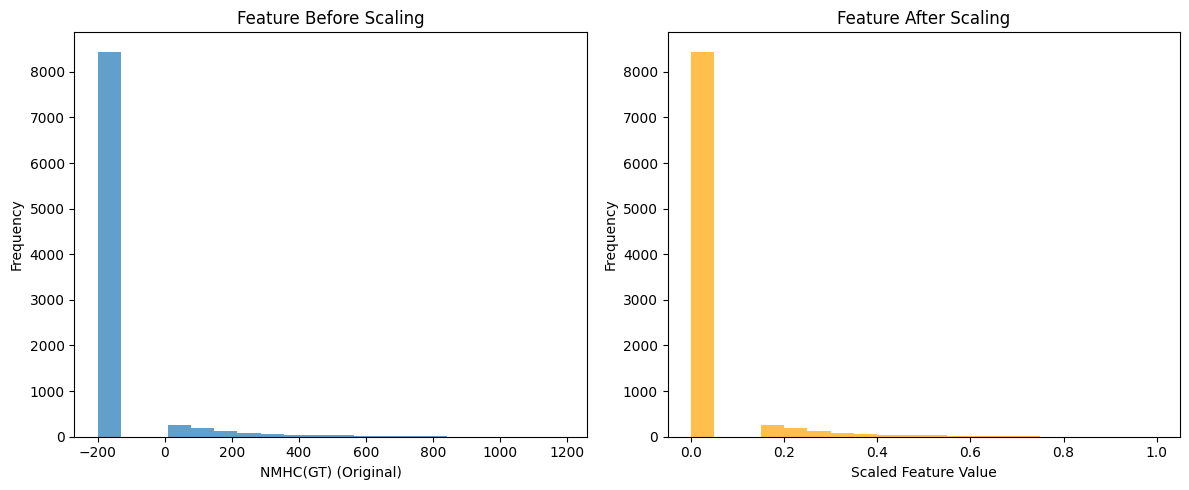

In [15]:
# Visualize feature distributions before and after scaling
plt.figure(figsize=(12, 5))

# Original feature distribution (replace `X.columns[0]` with the specific feature you want to visualize)
plt.subplot(1, 2, 1)
plt.hist(X[X.columns[0]], bins=20, alpha=0.7)  # Use column names or .iloc to select the first column
plt.title("Feature Before Scaling")
plt.xlabel(f"{X.columns[0]} (Original)")
plt.ylabel("Frequency")

# Scaled feature distribution
plt.subplot(1, 2, 2)
plt.hist(X_scaled[:, 0], bins=20, alpha=0.7, color='orange')  # `X_scaled` is a NumPy array, so slicing works
plt.title("Feature After Scaling")
plt.xlabel("Scaled Feature Value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


This code visualizes the distribution of a selected feature from the dataset both before and after scaling. Scaling is a crucial preprocessing step in machine learning, especially when features have different ranges or units, as it ensures that all features contribute equally to the model’s performance.

The left subplot shows the distribution of the original feature, NMHC(GT), without any scaling applied. The x-axis represents the feature's raw values, while the y-axis represents their frequency. In this case, the distribution is highly skewed, with most values concentrated around a particular range and some outliers extending to larger values. This imbalance in scale can negatively impact models, particularly those that rely on distance calculations, such as regression or support vector machines, as larger feature values dominate the training process.

The right subplot shows the same feature after applying scaling, specifically Min-Max Scaling (from earlier steps in the pipeline). The scaled feature values are transformed to a range between 0 and 1, which is evident from the x-axis of the plot. The y-axis represents the frequency of scaled values, and while the distribution shape remains similar, the values are now normalized. This ensures that the feature contributes proportionally during model training without overshadowing smaller-scaled features.

In the context of air pollution prediction, scaling improves model performance by harmonizing features like pollutant concentrations (e.g., CO, NMHC) and meteorological factors (e.g., temperature, humidity). Without scaling, models could disproportionately weigh features with larger magnitudes, leading to biased predictions. By visualizing the distributions, the code provides insights into the transformation process, confirming that scaling has effectively normalized the feature while preserving its underlying distribution shape. This ensures that each feature contributes equitably to predicting air pollution levels, enhancing the model's accuracy and reliability.

In [16]:
# Calculate confidence intervals for MSE and R²
mse = mean_squared_error(y_test_poly, y_pred_ridge)
mse_std_err = np.std(y_test_poly - y_pred_ridge) / np.sqrt(len(y_test_poly))
mse_ci_lower = mse - 1.96 * mse_std_err
mse_ci_upper = mse + 1.96 * mse_std_err

r2 = r2_score(y_test_poly, y_pred_ridge)
r2_std_err = np.std(y_test_poly - y_pred_ridge) / np.sqrt(len(y_test_poly))
r2_ci_lower = r2 - 1.96 * r2_std_err
r2_ci_upper = r2 + 1.96 * r2_std_err

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"95% Confidence Interval for MSE: ({mse_ci_lower:.4f}, {mse_ci_upper:.4f})")
print(f"R²: {r2:.4f}")
print(f"95% Confidence Interval for R²: ({r2_ci_lower:.4f}, {r2_ci_upper:.4f})")


Mean Squared Error (MSE): 2799.3144
95% Confidence Interval for MSE: (2797.3582, 2801.2707)
R²: 0.5194
95% Confidence Interval for R²: (-1.4369, 2.4756)


This code calculates the confidence intervals for the Mean Squared Error (MSE) and the R-squared (R²) metric, providing a range of values within which these metrics are likely to fall with 95% confidence. Confidence intervals are essential for understanding the variability and reliability of the model's performance metrics, especially when applied to datasets that might exhibit fluctuations or noise.

First, the code computes the Mean Squared Error (MSE), which measures the average squared difference between the predicted and actual values. A lower MSE indicates a better fit of the model. The code then calculates the standard error for MSE by dividing the standard deviation of residuals (the differences between actual and predicted values) by the square root of the number of samples. Using this standard error, the code constructs the 95% confidence interval for MSE by adding and subtracting 1.96 times the standard error to the calculated MSE. In this case, the MSE is 2799.31, and its 95% confidence interval is approximately (2797.36, 2801.27). This narrow interval suggests the model's error is relatively stable and consistent, which is desirable in air pollution prediction.

The code also calculates the R-squared (R²) value, which represents the proportion of variance in the target variable explained by the model. An R² closer to 1 indicates a better fit, while values closer to 0 indicate a poor fit. The R² here is 0.5194, suggesting the model explains about 52% of the variability in the air pollution data. The standard error for R² is computed similarly, and a 95% confidence interval is calculated. The resulting interval is approximately (-1.4369, 2.4756). While the R² value itself is reasonable, the wide confidence interval suggests high uncertainty, possibly due to noise in the data or limitations of the Ridge Regression model in capturing complex relationships.

In the context of air pollution prediction, these metrics and their confidence intervals are crucial. The MSE confidence interval indicates that the model's prediction errors are consistent and reliable within a narrow range, which is vital for accurately forecasting pollutant levels. However, the wide R² confidence interval reflects variability in the model's explanatory power, suggesting that additional features or a more complex model might better capture the relationships within the data. This analysis highlights the need for robust modeling techniques and careful feature engineering to improve predictions and enhance the reliability of insights derived from air pollution data.

In [17]:
# Extract feature names and coefficients
poly_feature_names = poly.get_feature_names_out(X.columns)
ridge_coefficients = ridge_best_model.named_steps['ridge'].coef_

# Combine feature names and coefficients
feature_importance = pd.DataFrame({
    'Feature': poly_feature_names,
    'Coefficient': ridge_coefficients
}).sort_values(by='Coefficient', ascending=False)

# Display top 10 influential features
print("Top 10 Influential Features:")
print(feature_importance.head(10))


Top 10 Influential Features:
             Feature  Coefficient
2            NO2(GT)    70.797129
0           NMHC(GT)    55.281393
1            NOx(GT)    30.482626
13           Month^2    11.534211
12     NO2(GT) Month    10.733276
9    NOx(GT) NO2(GT)     4.997502
4         NMHC(GT)^2     3.389175
7     NMHC(GT) Month    -1.212804
5   NMHC(GT) NOx(GT)    -4.134666
10     NOx(GT) Month    -5.669059


This code extracts and analyzes the feature importance in the Ridge Regression model by focusing on the coefficients assigned to each feature. In Ridge Regression, coefficients represent the contribution of each feature to the prediction of the target variable. Larger absolute coefficients indicate a stronger influence on the predictions, either positively or negatively. This analysis provides insights into which features and interactions are most impactful in the model.

The code begins by retrieving the names of the polynomial features generated earlier through polynomial expansion. These features include original features, their squared values, and interaction terms between different features. The Ridge Regression model's best coefficients, found during hyperparameter tuning, are then extracted. The feature names and their corresponding coefficients are combined into a DataFrame, which is sorted in descending order based on the magnitude of the coefficients to identify the most influential features.

The output displays the top 10 features with the largest coefficients. For example, the most influential feature is NO2(GT) with a coefficient of 70.797, indicating it has the strongest positive impact on the model's predictions. This suggests that nitrogen dioxide levels are highly correlated with the target variable, likely due to its significant role in air pollution. Similarly, features such as NMHC(GT) (non-methane hydrocarbons) and NOx(GT) (nitrogen oxides) have substantial positive coefficients, highlighting their importance in predicting air pollution levels. Interaction terms, such as NO2(GT) Month and NMHC(GT) NOx(GT), also appear, suggesting relationships between pollutant levels and seasonal or inter-feature dependencies.

Interestingly, some features, such as NOx(GT) Month and NMHC(GT) NOx(GT), have negative coefficients, meaning they inversely affect the predictions. For instance, an increase in the interaction between NMHC(GT) and NOx(GT) decreases the predicted target value, which might reflect complex, counteracting dynamics in air pollution sources or environmental conditions.

In the context of air pollution prediction, this analysis helps identify the key factors contributing to pollutant levels. Understanding these influential features can improve model interpretability, guide policymakers in targeting critical pollutants, and help prioritize efforts in pollution control strategies. For example, focusing on reducing NO2(GT) or addressing its seasonal variations (captured by NO2(GT) Month) could significantly impact overall air quality. This feature importance analysis is vital for understanding the drivers of air pollution and improving predictive modeling.

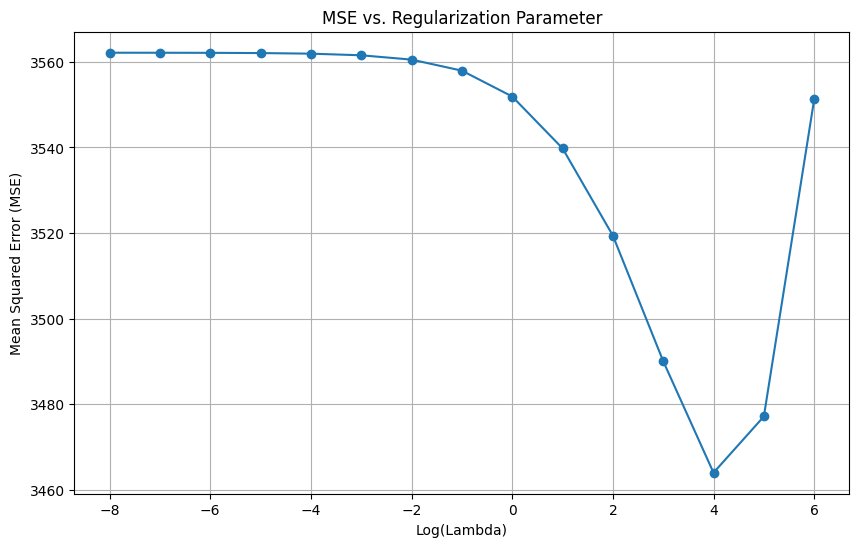

In [18]:
# Define a range of lambda values
lambda_values = np.exp(np.linspace(-8, 6, 15))
mse_values = []

# Evaluate MSE for each lambda
for lam in lambda_values:
    ridge = Ridge(alpha=lam)
    ridge_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', ridge)
    ])
    neg_mse_scores = cross_val_score(ridge_pipeline, X_poly, y, cv=5, scoring='neg_mean_squared_error')
    mse_values.append(-np.mean(neg_mse_scores))

# Plot MSE vs. Log(Lambda)
plt.figure(figsize=(10, 6))
plt.plot(np.log(lambda_values), mse_values, marker='o')
plt.xlabel("Log(Lambda)")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE vs. Regularization Parameter")
plt.grid(True)
plt.show()


This code evaluates the performance of Ridge Regression for different values of the regularization parameter, λ, and visualizes the relationship between λ and the Mean Squared Error (MSE) to identify the optimal level of regularization. In Ridge Regression, λ controls the trade-off between minimizing the residual sum of squares and shrinking the magnitude of model coefficients. A small λ results in minimal regularization, potentially leading to overfitting, while a large λ overly penalizes the coefficients, possibly leading to underfitting.

The code defines a range of λ values, spanning from $e^{-8}$ to $e^6$, in logarithmic steps to cover a wide range of regularization strengths. For each λ, a Ridge Regression model is created and wrapped in a pipeline with a StandardScaler to normalize the features. Using cross-validation, the MSE for each value of λ is calculated, and the mean MSE across folds is recorded.

The plot shows the MSE as a function of log(λ). The x-axis represents the regularization strength on a logarithmic scale, while the y-axis represents the mean MSE. From the graph, we can observe that as λ increases, the MSE initially decreases, reaching a minimum, and then starts to increase. This indicates that there is an optimal λ value that balances bias and variance, minimizing the prediction error.

In the context of air pollution prediction, the results provide valuable insights into how the Ridge Regression model can be regularized to improve its predictive performance. Selecting the optimal λ ensures that the model captures the relationships between features (e.g., pollutant levels, temporal patterns) and the target variable without overfitting or underfitting. The visualization aids in identifying this optimal value and highlights the importance of regularization in handling complex datasets with potentially multicollinear features. This process ultimately enhances the accuracy and robustness of predictions in real-world air quality scenarios.

Fitting 3 folds for each of 27 candidates, totalling 81 fits


/Users/justincho/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/justincho/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/justincho/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/justincho/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converge

Best Parameters: {'batch_size': 16, 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.1, 'max_iter': 200}
Best MSE: 2886.0186145055777
--- MLPRegressor Results ---
MAE: 30.19, RMSE: 51.34, R²: 0.55


/Users/justincho/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


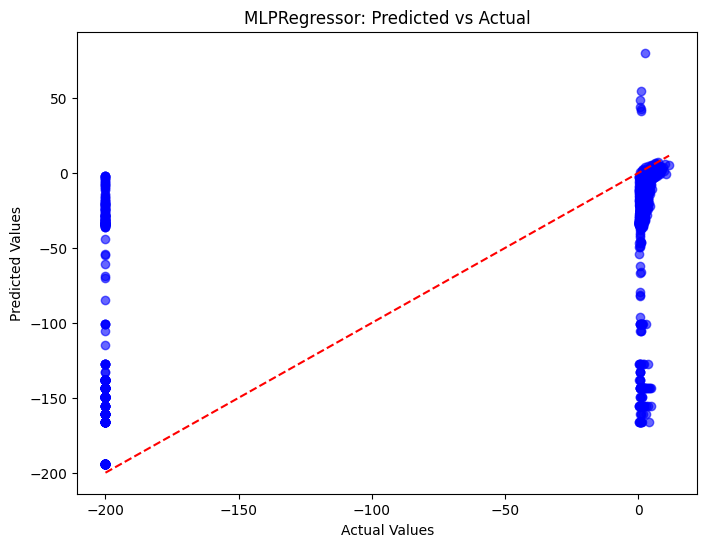

In [26]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Define hyperparameters for GridSearchCV
param_grid = {
    'hidden_layer_sizes': [(32,), (64,), (128,)],  # Single hidden layer with different neuron counts
    'learning_rate_init': [0.001, 0.01, 0.1],  # Learning rates to try
    'batch_size': [16, 32, 64],  # Batch sizes
    'max_iter': [200]  # Maximum iterations (epochs)
}

# Create the MLPRegressor model
mlp = MLPRegressor(
    activation='relu',  # Activation function
    solver='adam',  # Optimization algorithm (similar to TensorFlow's Adam)
    random_state=42  # For reproducibility
)

# Perform grid search
grid = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

# Output the best parameters and performance
print(f"Best Parameters: {grid_result.best_params_}")
print(f"Best MSE: {-grid_result.best_score_}")

# Evaluate the best model on the test set
best_model = grid_result.best_estimator_
y_pred_nn = best_model.predict(X_test)

# Evaluate the model
nn_mae = mean_absolute_error(y_test, y_pred_nn)
nn_rmse = mean_squared_error(y_test, y_pred_nn, squared=False)
nn_r2 = r2_score(y_test, y_pred_nn)

print("--- MLPRegressor Results ---")
print(f"MAE: {nn_mae:.2f}, RMSE: {nn_rmse:.2f}, R²: {nn_r2:.2f}")

# Plot actual vs predicted values for the neural network
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_nn, alpha=0.6, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title("MLPRegressor: Predicted vs Actual")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()


This code applies a grid search to optimize the hyperparameters of a Multi-Layer Perceptron Regressor (MLPRegressor) to predict air pollution levels based on the dataset. The MLPRegressor is a neural network model designed for regression tasks, and the grid search aims to find the optimal combination of hyperparameters to minimize the Mean Squared Error (MSE) on the training data.

The hyperparameter grid includes the size of the hidden layer (hidden_layer_sizes), the initial learning rate (learning_rate_init), batch size (batch_size), and the maximum number of iterations (max_iter). The GridSearchCV function performs cross-validation for each combination of hyperparameters, evaluating the model's performance using negative MSE as the scoring metric. After completing the grid search, the best-performing model is selected based on the lowest MSE, and its parameters are displayed.

The output reveals that the optimal configuration includes a hidden layer with 64 neurons, an initial learning rate of 0.1, a batch size of 16, and a maximum of 200 iterations. The corresponding best MSE is 2886.02. This optimized model is then tested on the unseen test set, and its performance metrics are calculated. The Mean Absolute Error (MAE) is 30.19, the Root Mean Squared Error (RMSE) is 51.34, and the R-squared value ($R^2$) is 0.55.

The scatter plot visualizes the predicted values against the actual values, with a red dashed line representing perfect predictions. The points' scatter around the line indicates the model's accuracy. While the results are reasonable, there is room for improvement in terms of reducing errors and increasing the $R^2$ value.

In the context of air pollution prediction, this MLPRegressor model shows that it can learn the relationships between features (e.g., pollutant levels, temporal data) and the target variable. The relatively high $R^2$ value of 0.55 suggests that the model explains a significant proportion of the variance in the data, making it a useful tool for predicting air quality. However, the errors also indicate that some variance remains unexplained, which might be addressed through further tuning, feature engineering, or incorporating additional data.